In [386]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
def seed_torch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_torch(1)

In [387]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, code_dim, activation=None):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, code_dim, dtype=torch.float64)
        self.decoder = nn.Linear(code_dim, input_dim, dtype=torch.float64)
        self.activation = activation
    
    def forward(self, x):
        if self.activation:
            encoded = self.activation(self.encoder(x))
            decoded = self.decoder(encoded)
        else:
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
        return decoded
    
def train_autoencoder(model, data, epochs=1000, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        reconstructed = model(data)
        loss = criterion(reconstructed, data)
        loss.backward()
        optimizer.step()
    return model, loss.item()

In [388]:
data = pd.read_csv('Pizza.csv')
features = data.iloc[:, 2:9].values
scalar = StandardScaler()
features = scalar.fit_transform(features)
X = torch.tensor(features, dtype=torch.float64).to(device)
input_dims, hid_dims = X.shape[1], range(1, 7)

In [389]:
linear_mse = []
for d in hid_dims:
    model = Autoencoder(input_dims, d).to(device)
    trained_model, mse = train_autoencoder(model, X)
    pred_y = trained_model(X)
    mse = torch.mean((X - pred_y) ** 2).item()
    linear_mse.append(mse)

In [390]:
linear_mse

[0.40403193452419,
 0.07682597991210265,
 0.017616095900308344,
 0.004011975411491773,
 0.00013383581524376465,
 6.844491261782902e-05]

In [421]:
W, V = trained_model.encoder.weight.data, trained_model.decoder.weight.data
Wb, Vb = trained_model.encoder.bias, trained_model.decoder.bias
V @ (W @ X[0] + Wb) + Vb

tensor([-1.3725,  1.2545,  2.7516,  1.9540,  2.9774, -1.2271,  2.6791],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [382]:
relu_mse = []
for d in hid_dims:
    relu_model = Autoencoder(input_dims, d, activation=nn.ReLU()).to(device)
    relu_model, mse = train_autoencoder(relu_model, X)
    reconstructed = relu_model(X)
    mse = torch.mean((X - reconstructed) ** 2).item()
    relu_mse.append(mse)

In [383]:
relu_mse

[0.40518365403161505,
 0.07690300035020228,
 0.01784063757110578,
 0.012712648487494026,
 0.002643713400143867,
 0.0005559577047198795]

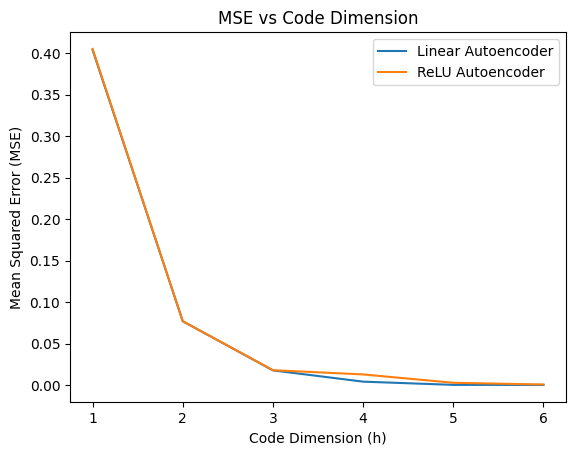

In [ ]:
plt.plot(hid_dims, linear_mse, label='Linear Autoencoder')
plt.plot(hid_dims, relu_mse, label='ReLU Autoencoder')
plt.xlabel('Code Dimension (h)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Code Dimension')
plt.legend()
plt.show()
# plt.savefig('q1.png', dpi=400)